<a href="https://colab.research.google.com/github/Javieraicgm/Redes_Neuronales_Repo/blob/master/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enviroment:

Python=3.10 \\
keras-cv==0.5.1 \\
keras-core \\
Tensor flow \\

In [11]:
!pip install keras-cv==0.5.1
!pip install keras-core

In [12]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

In [13]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')

download_file(
    'https://www.dropbox.com/scl/fi/suext2oyjxa0v4p78bj3o/S2TLD_720x1280.zip?rlkey=iequuynn54uib0uhsc7eqfci4&dl=1',
    'S2TLD_720x1280.zip')

File already present


In [14]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('S2TLD_720x1280.zip')

Extracted all


In [15]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCH = 2
GLOBAL_CLIPNORM = 10.0

In [16]:
class_ids = ["red","yellow","green","off",]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "S2TLD_720x1280/images/"
path_annot = "S2TLD_720x1280/annotations/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted([
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")])

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted([
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")])

In [17]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4564 [00:00<?, ?it/s]

In [18]:
classes

[[0, 0, 0, 0],
 [0, 0],
 [0, 0, 0, 0],
 [2, 2, 2],
 [3, 2, 2, 2, 2, 0, 0],
 [2, 2, 0],
 [2],
 [2, 2],
 [0, 0],
 [2, 2, 2, 2, 3, 3],
 [2, 2, 0, 0],
 [0],
 [0, 0, 2, 2, 2, 2, 3],
 [0, 2],
 [0],
 [2, 2],
 [0, 0, 0],
 [2, 2, 0, 0],
 [2, 2, 2],
 [2, 2, 2],
 [0],
 [2, 2, 0, 0],
 [2, 2],
 [0, 0],
 [2, 2],
 [2, 2, 0, 0],
 [2, 2],
 [0, 0, 2, 2],
 [0, 0, 0, 0],
 [0, 0, 2, 2],
 [2, 2, 2, 3, 3],
 [0],
 [0, 0, 0, 2, 2, 2],
 [0, 0],
 [0, 0, 2, 2],
 [2, 2],
 [1, 1],
 [0],
 [2, 2],
 [2, 2, 0, 0],
 [2],
 [2],
 [0, 0, 1, 1],
 [2, 2, 2],
 [3, 2, 2, 2, 3],
 [0],
 [2, 3],
 [2, 2, 0, 0, 2],
 [2],
 [2],
 [2, 2, 2],
 [2, 2],
 [0, 0],
 [2, 2],
 [0],
 [2, 2, 2, 3, 3],
 [2, 2, 0, 0],
 [2],
 [0, 0],
 [3, 3, 2, 2, 2],
 [3, 3, 2, 2, 2],
 [2, 2],
 [2, 2, 2, 3, 3],
 [2, 2],
 [3, 2],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [2, 2],
 [0, 0, 2, 2, 2],
 [0, 0, 0, 0, 0],
 [2, 2],
 [0],
 [2, 2, 0],
 [2, 2, 0, 0],
 [0],
 [2, 2, 2],
 [2, 2, 2, 0, 0, 0],
 [0, 0, 0, 0],
 [2, 2],
 [2, 2],
 [2, 2],
 [0, 0],
 [2, 2, 2],
 [2, 2, 2, 2, 3],
 

In [19]:
bbox

[[[190.0, 126.0, 217.0, 183.0],
  [241.0, 120.0, 265.0, 172.0],
  [894.0, 146.0, 922.0, 202.0],
  [956.0, 145.0, 983.0, 200.0]],
 [[641.0, 81.0, 676.0, 161.0], [1100.0, 94.0, 1133.0, 162.0]],
 [[244.0, 180.0, 267.0, 229.0],
  [322.0, 176.0, 343.0, 226.0],
  [1181.0, 165.0, 1201.0, 213.0],
  [1249.0, 168.0, 1272.0, 219.0]],
 [[700.0, 221.0, 717.0, 257.0],
  [991.0, 225.0, 1011.0, 259.0],
  [496.0, 2.0, 541.0, 77.0]],
 [[675.0, 193.0, 694.0, 236.0],
  [728.0, 190.0, 744.0, 232.0],
  [731.0, 258.0, 744.0, 281.0],
  [755.0, 254.0, 765.0, 279.0],
  [845.0, 271.0, 855.0, 293.0],
  [836.0, 271.0, 844.0, 292.0],
  [713.0, 259.0, 724.0, 284.0]],
 [[14.0, 87.0, 39.0, 151.0],
  [894.0, 112.0, 923.0, 185.0],
  [810.0, 113.0, 850.0, 184.0]],
 [[544.0, 222.0, 563.0, 262.0]],
 [[636.0, 221.0, 656.0, 258.0], [843.0, 218.0, 863.0, 256.0]],
 [[611.0, 41.0, 644.0, 124.0], [884.0, 37.0, 921.0, 128.0]],
 [[165.0, 252.0, 196.0, 320.0],
  [901.0, 221.0, 932.0, 292.0],
  [683.0, 304.0, 689.0, 321.0],
  [696.0

In [20]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [21]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [22]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {"classes": tf.cast(classes, dtype=tf.float32),"boxes": bbox,}
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = keras.Sequential(
    layers=[keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
            keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",),])

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
resizing = keras_cv.layers.JitteredResize(target_size=(640, 640),
                                          scale_factor=(1.0, 1.0),
                                          bounding_box_format="xyxy",)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

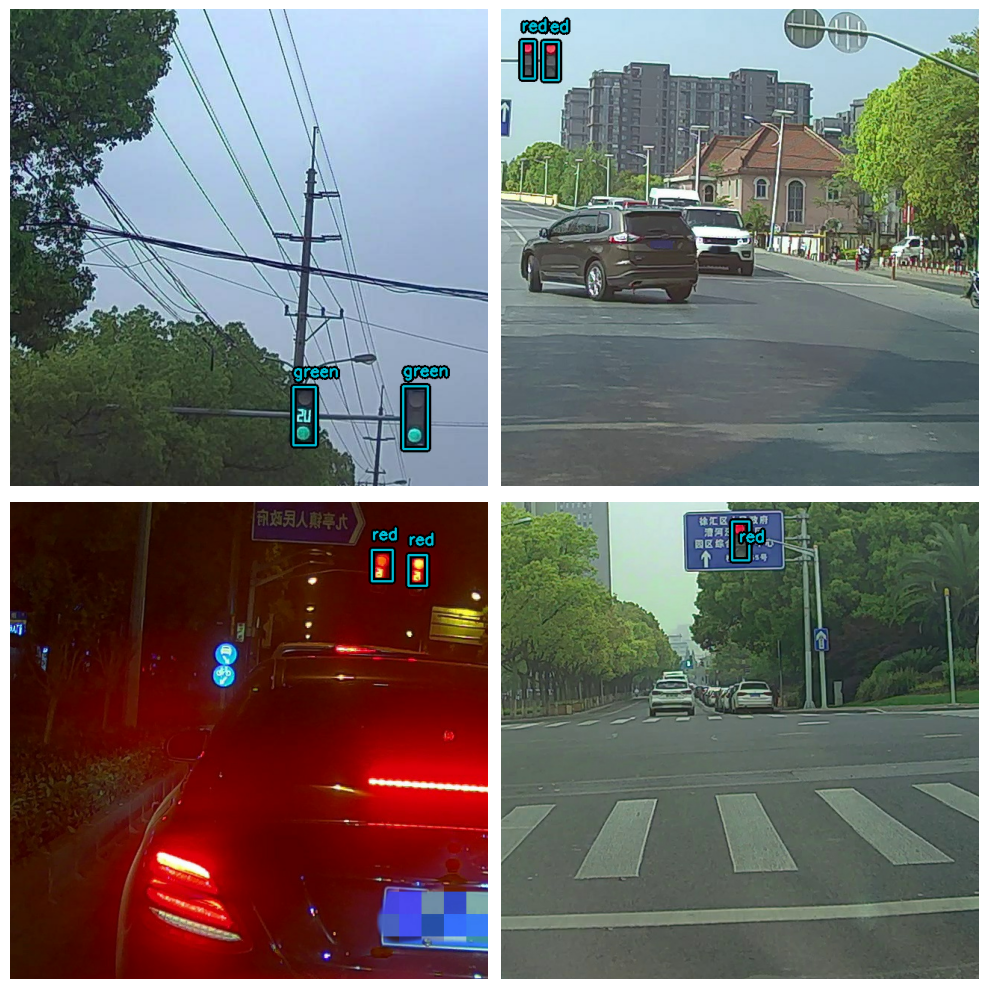

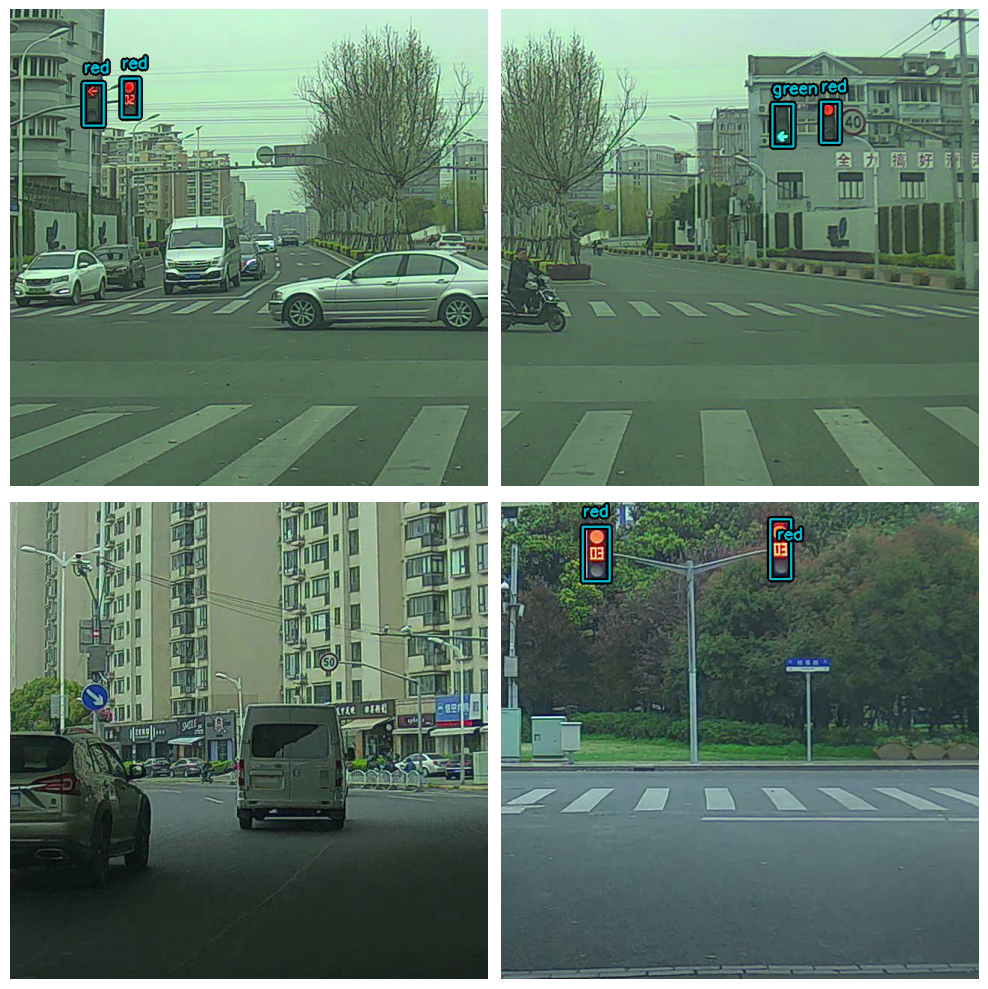

In [24]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,)


visualize_dataset(train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

visualize_dataset(val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

In [25]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [26]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_l_backbone_coco",load_weights=True)

yolo = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                      bounding_box_format="xyxy",
                                      backbone=backbone,
                                      fpn_depth=3,)

yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1983174   ['input_2[0][0]']             
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,global_clipnorm=GLOBAL_CLIPNORM,)

yolo.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")

In [28]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(bounding_box_format="xyxy",evaluate_freq=1e9,)
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [ ]:
history = yolo.fit(train_ds,
                   validation_data=val_ds,
                   epochs=EPOCH,
                   callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),tensorboard_callback],)

Epoch 1/2
  1/456 [..............................] - ETA: 20:23:53 - loss: 12408.6270 - box_loss: 6.5995 - class_loss: 12402.0273